Buckling of a Composite Plate
===

Plate geometry and laminate data
---

In [1]:
a = 0.406
b = 0.254

E1 = 1.295e11
E2 = 9.37e9
nu12 = 0.38
G12 = 5.24e9
G13 = 5.24e9
G23 = 5.24e9
plyt = 1.9e-4
laminaprop = (E1, E2, nu12, G12, G13, G23)

angles = [0, 45, -45, 90, 90, -45, 45, 0]


Generating Mesh
---

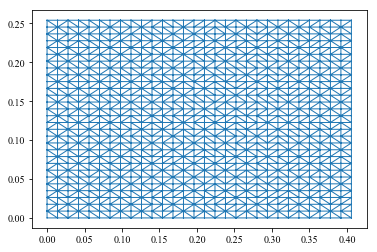

In [2]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

xs = np.linspace(0, a, 30)
ys = np.linspace(0, b, 30)
points = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)
tri = Delaunay(points)
plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
plt.show()

Using Meshless Package
---

In [4]:
from scipy.sparse import coo_matrix

from meshless.composite.laminate import read_stack
from meshless.sparse import solve
from meshless.linear_buckling import lb
from meshless.espim.read_mesh import read_delaunay
from meshless.espim.plate2d_calc_k0 import calc_k0
from meshless.espim.plate2d_calc_kG import calc_kG
from meshless.espim.plate2d_add_k0s import add_k0s

mesh = read_delaunay(points, tri)
nodes = np.array(list(mesh.nodes.values()))
prop_from_nodes = True

nodes_xyz = np.array([n.xyz for n in nodes])

**Applying laminate properties**

In [5]:
# applying heterogeneous properties
for node in nodes:
    xyz = node.xyz
    lam = read_stack(angles, plyt=plyt, laminaprop=laminaprop)
    node.prop = lam

**Defining Boundary Conditions**


In [6]:
DOF = 5
def bc(K, mesh):
    for node in nodes[nodes_xyz[:, 0] == xs.min()]:
        for dof in [1, 3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0
    for node in nodes[(nodes_xyz[:, 1] == ys.min()) |
                      (nodes_xyz[:, 1] == ys.max())]:
        for dof in [2, 3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0
    for node in nodes[nodes_xyz[:, 0] == xs.max()]:
        for dof in [3]:
            j = dof-1
            K[node.index*DOF+j, :] = 0
            K[:, node.index*DOF+j] = 0

**Calculating Constitutive Stiffness Matrix**

In [7]:
k0s_method = 'cell-based'
k0 = calc_k0(mesh, prop_from_nodes)
add_k0s(k0, mesh, prop_from_nodes, k0s_method)
bc(k0, mesh)
k0 = coo_matrix(k0)

**Defining Load and External Force Vector**

In [8]:
def define_loads(mesh):
    loads = []
    load_nodes = nodes[(nodes_xyz[:, 0] == xs.max()) &
                       (nodes_xyz[:, 1] != ys.min()) &
                       (nodes_xyz[:, 1] != ys.max())]
    fx = -1. / (nodes[nodes_xyz[:, 0] == xs.max()].shape[0] - 1)
    for node in load_nodes:
        loads.append([node, (fx, 0, 0)])
    load_nodes = nodes[(nodes_xyz[:, 0] == xs.max()) &
                       ((nodes_xyz[:, 1] == ys.min()) |
                        (nodes_xyz[:, 1] == ys.max()))]
    fx = -1. / (nodes[nodes_xyz[:, 0] == xs.max()].shape[0] - 1) / 2
    for node in load_nodes:
        loads.append([node, (fx, 0, 0)])
    return loads
    
n = k0.shape[0] // DOF
fext = np.zeros(n*DOF, dtype=np.float64)
loads = define_loads(mesh)
for node, force_xyz in loads:
    fext[node.index*DOF + 0] = force_xyz[0]
print('Checking sum of forces: %s' % str(fext.reshape(-1, DOF).sum(axis=0)))

Checking sum of forces: [-1.  0.  0.  0.  0.]


**Running Static Analysis**

In [9]:
d = solve(k0, fext, silent=True)
total_trans = (d[0::DOF]**2 + d[1::DOF]**2)**0.5
print('Max total translation', total_trans.max())

Max total translation 1.87297804107e-08


**Calculating Geometric Stiffness Matrix**

In [10]:
kG = calc_kG(d, mesh, prop_from_nodes)
bc(kG, mesh)
kG = coo_matrix(kG)

**Running Linear Buckling Analysis**

In [11]:
eigvals, eigvecs = lb(k0, kG, silent=True)
print('First 5 eigenvalues')
print('\n'.join(map(str, eigvals[0:5])))

First 5 eigenvalues
1204.53223877
2379.09235471
3846.02806366
4320.80812017
5005.02652595


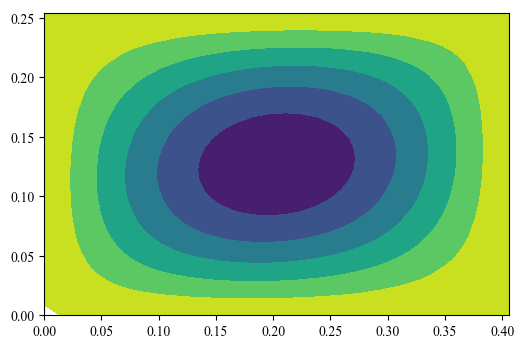

In [12]:
import matplotlib.pyplot as plt

ind0 = np.array([[n.index, i] for (i, n) in enumerate(nodes)])
ind0 = ind0[np.argsort(ind0[:, 0])]
nodes_in_k0 = nodes[ind0[:, 1]]
xyz = np.array([n.xyz for n in nodes_in_k0])
ind = np.lexsort((xyz[:, 1], xyz[:, 0]))
w = eigvecs[:, 0][2::DOF][ind]
xyz = xyz[ind]
plt.figure(dpi=100)
plt.tricontourf(xyz[:, 0], xyz[:, 1], w)
plt.show()
